# Experiment results Kalman Filter

In [17]:
#Preliminary imports
import dfm_tools as dfmt
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
plt.rcParams['figure.dpi'] = 330
cm=1/2.54

#### Compare reference run of cut-out with experiment results for the complete RMM 2D

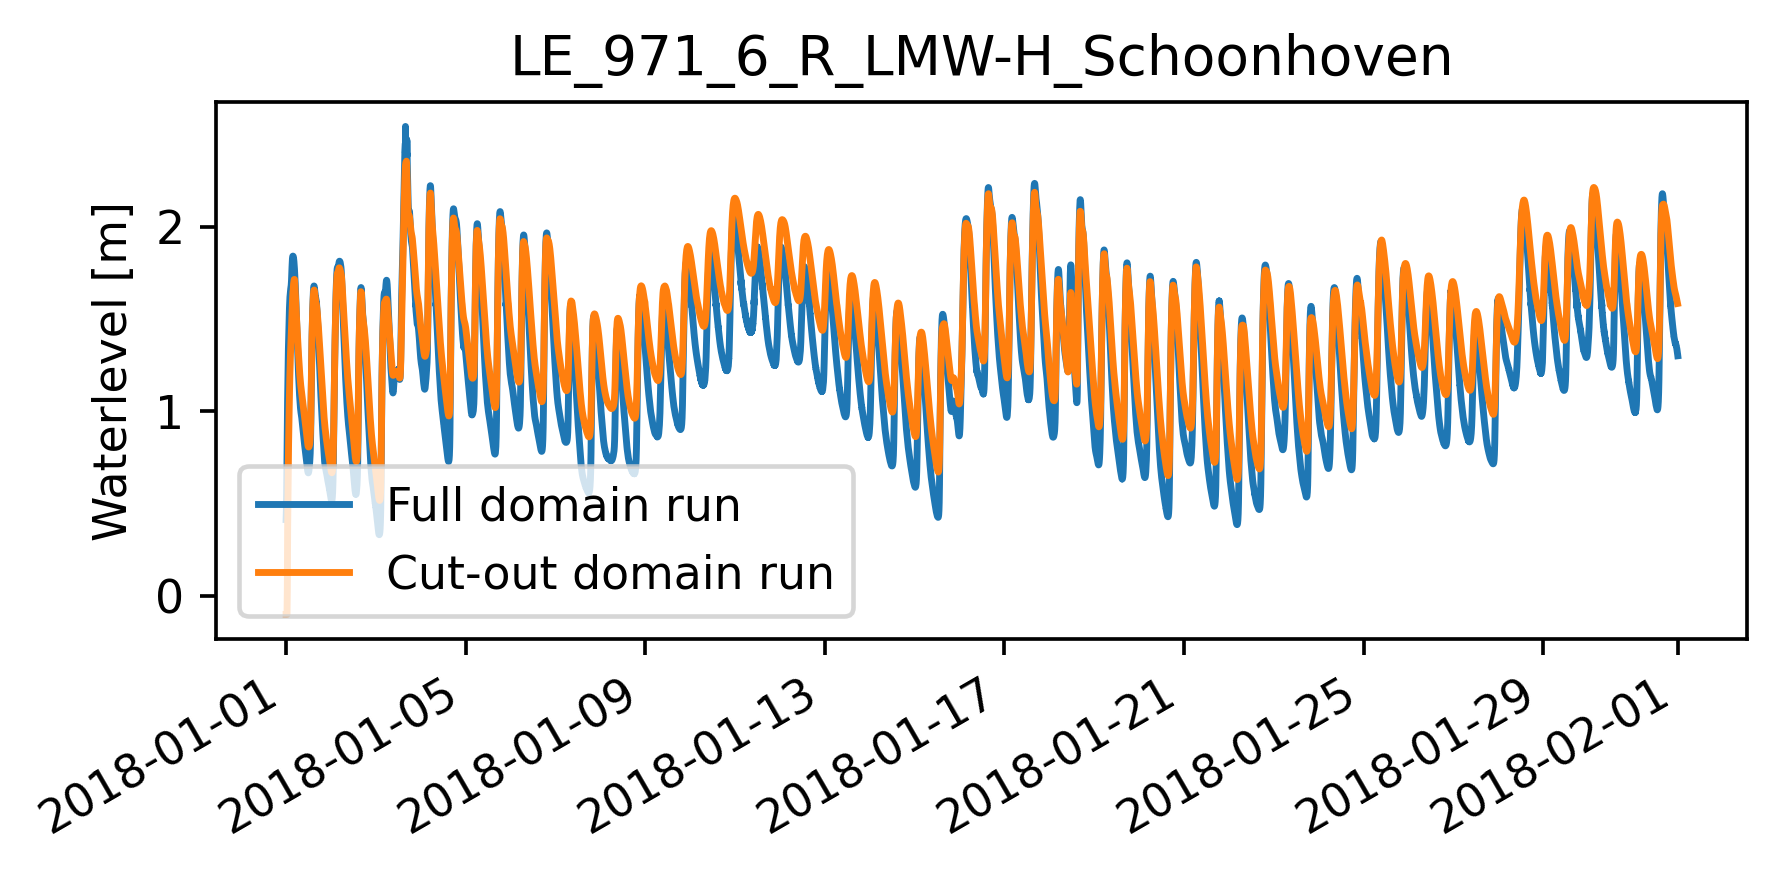

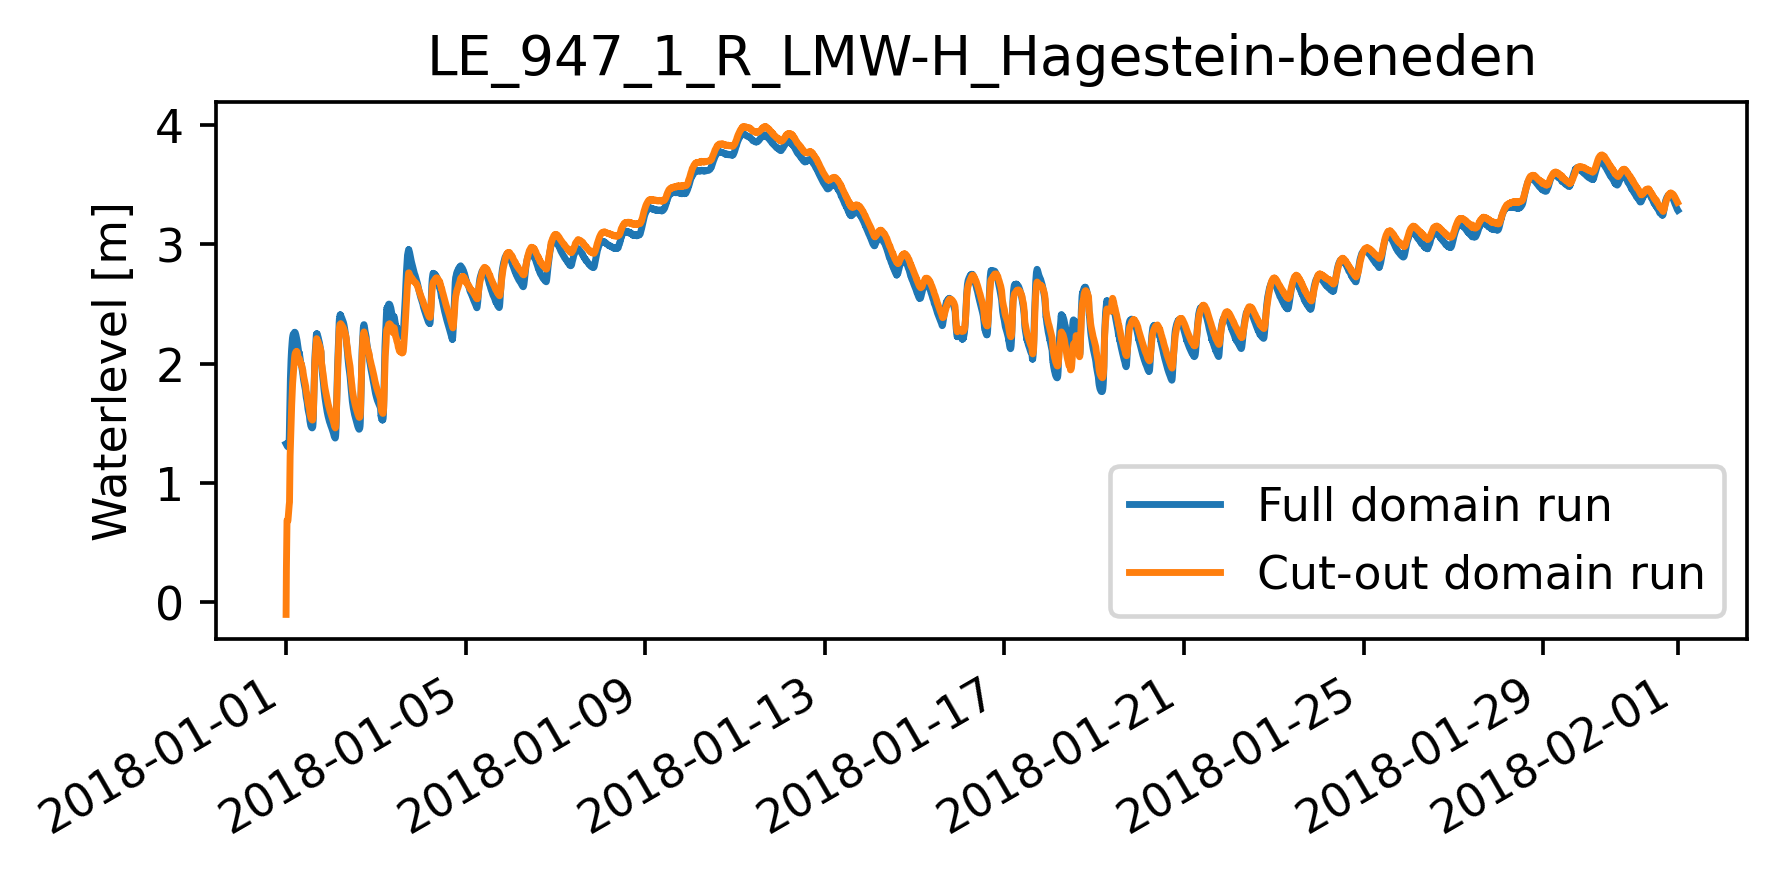

In [19]:
#Set output directory for these files
outputdir = Path(r'p:\11208053-004-kpp2022-rmm1d2d\C_Work\09_Validatie2018_2020\dflowfm2d-rmm_vzm-j19_6-v2d\computations\validation\KalmanFilterDischarge\Experiment_Outputs\Simulation_Discharge_Noise_0\Figures')

#Load hisfiles from full model and plot waterlevels for relevant stations
his_full_model = xr.open_mfdataset(r'p:\11208053-004-kpp2022-rmm1d2d\C_Work\09_Validatie2018_2020\dflowfm2d-rmm_vzm-j19_6-v2d\computations\validation\2018_Validation_run_1_entire_period\results\RMM_VZM_0000_wl_his.nc',
                                        preprocess = dfmt.preprocess_hisnc)
his_reference_model = xr.open_mfdataset(r'..\Experiment_Outputs\Simulation_Discharge_Noise_0\work0\results\full_RMM_VZM_his.nc',
                                        preprocess = dfmt.preprocess_hisnc)         

plot_stations_reference = ['LE_971_6_R_LMW-H_Schoonhoven', 
                 'LE_947_1_R_LMW-H_Hagestein-beneden']

plot_stations_full = ['LE_971.6_R_LMW-H_Schoonhoven', 
                 'LE_947.1_R_LMW-H_Hagestein-beneden']

for iStation, station in enumerate(plot_stations_reference):
    fig, ax = plt.subplots(1,1, figsize = (14*cm, 7*cm))
    his_full_model['waterlevel'].sel(stations=plot_stations_full[iStation]).sel(time='2018-01').plot(ax=ax, label='Full domain run')
    his_reference_model['waterlevel'].sel(stations=station).sel(time='2018-01').plot(ax=ax, label='Cut-out domain run')
    ax.set_ylabel('Waterlevel [m]')
    ax.set_xlabel('')
    ax.set_title(station)
    plt.legend()
    plt.tight_layout()
    plt.savefig(outputdir / f'Waterlevel_Timeseries_Comparison_Full_Model_{station}.png')

### Analyse results of Kalman Filter

In [4]:
#Necesary imports from hydrolib
from hydrolib.core.io.bc.models import (
    ForcingModel,
    QuantityUnitPair,
    VerticalPositionType,
    TimeInterpolation,
    TimeSeries,
)

In [14]:
#Load Lek river discharge
River_Dischargefile = Path(r'p:\11208053-004-kpp2022-rmm1d2d\C_Work\09_Validatie2018_2020\dflowfm2d-rmm_vzm-j19_6-v2d\boundary_conditions\rmm_rivdis_meas_20171101_20210102_MET.bc')
forcing = ForcingModel(River_Dischargefile)
River_Discharge = dfmt.forcinglike_to_Dataset(forcing.forcing[0], convertnan=True)

#Load truth run discharge noise
EnKF_DischargeNoisefile = Path(r'p:\11208053-004-kpp2022-rmm1d2d\C_Work\09_Validatie2018_2020\dflowfm2d-rmm_vzm-j19_6-v2d\computations\validation\KalmanFilterDischarge\Experiment_Outputs\EnKF_Twin_Experiment_Noise_20\output\work0\discharge_noise_lek.bc')
forcing = ForcingModel(EnKF_DischargeNoisefile)
EnKF_DischargeNoise = dfmt.forcinglike_to_Dataset(forcing.forcing[0], convertnan=True)

#Load KF run discharge noise
Truth_DischargeNoisefile = Path(r'p:\11208053-004-kpp2022-rmm1d2d\C_Work\09_Validatie2018_2020\dflowfm2d-rmm_vzm-j19_6-v2d\computations\validation\KalmanFilterDischarge\Experiment_Outputs\Simulation_Discharge_Noise_20\work0\discharge_noise_lek.bc')
forcing = ForcingModel(Truth_DischargeNoisefile)
Truth_DischargeNoise = dfmt.forcinglike_to_Dataset(forcing.forcing[0], convertnan=True)


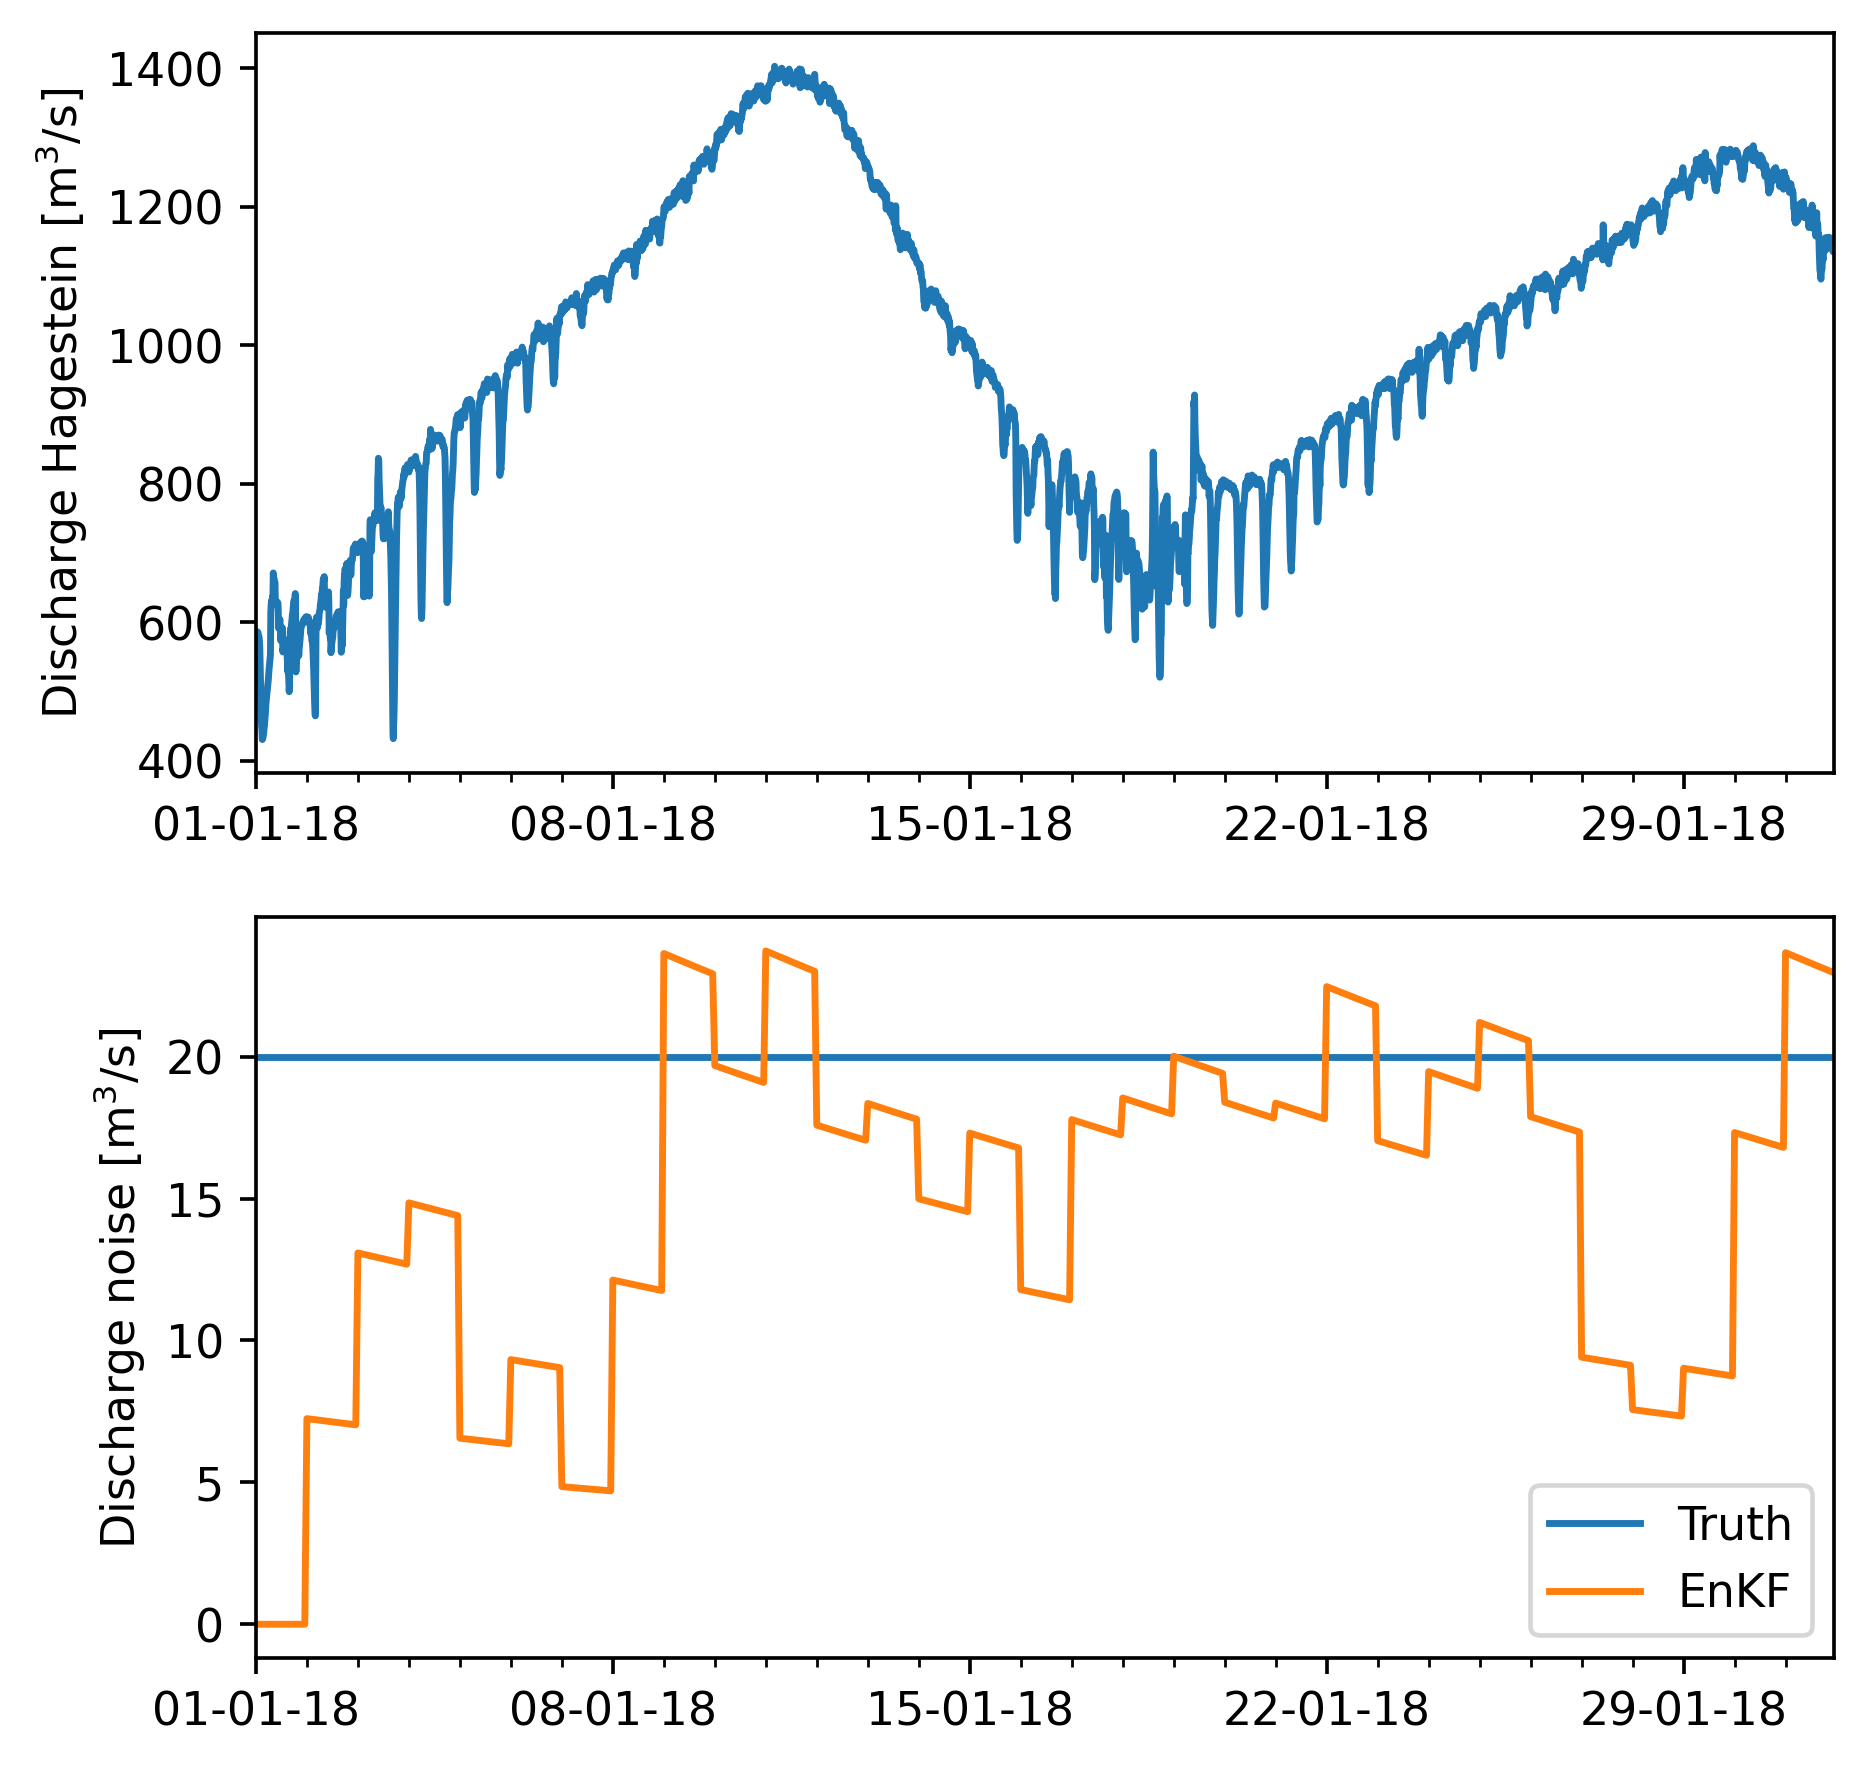

In [37]:
#Make figure of boundary discharge and noises
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (14*cm, 14*cm))
plt.tight_layout()
River_Discharge['dischargebnd'].sel(time='2018-01').plot(ax=ax1)
ax1.set_ylabel('Discharge Hagestein [m$^3$/s]')
ax1.set_xlabel('')
ax1.xaxis.set_major_locator(mdates.DayLocator(bymonthday=range(1,31, 7)))
ax1.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))
ax1.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
for label in ax1.get_xticklabels():
    label.set_horizontalalignment('center')
ax1.set_xlim(left = Truth_DischargeNoise['dischargebnd'].sel(time='2018-01').time.data[0], 
            right = Truth_DischargeNoise['dischargebnd'].sel(time='2018-01').time.data[-1])
ax1.tick_params(labelrotation=0)

Truth_DischargeNoise['dischargebnd'].sel(time='2018-01').plot(ax=ax2, label='Truth')
EnKF_DischargeNoise['dischargebnd'].sel(time='2018-01').plot(ax=ax2, label='EnKF')
ax2.set_ylabel('Discharge noise [m$^3$/s]')
ax2.set_xlabel('')
ax2.xaxis.set_major_locator(mdates.DayLocator(bymonthday=range(1,31, 7)))
ax2.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))
ax2.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
for label in ax2.get_xticklabels():
    label.set_horizontalalignment('center')
ax2.set_xlim(left = Truth_DischargeNoise['dischargebnd'].sel(time='2018-01').time.data[0], 
            right = Truth_DischargeNoise['dischargebnd'].sel(time='2018-01').time.data[-1])
ax2.tick_params(labelrotation=0)
plt.legend()

##### See if hisfile results are closer with Kalman Filter

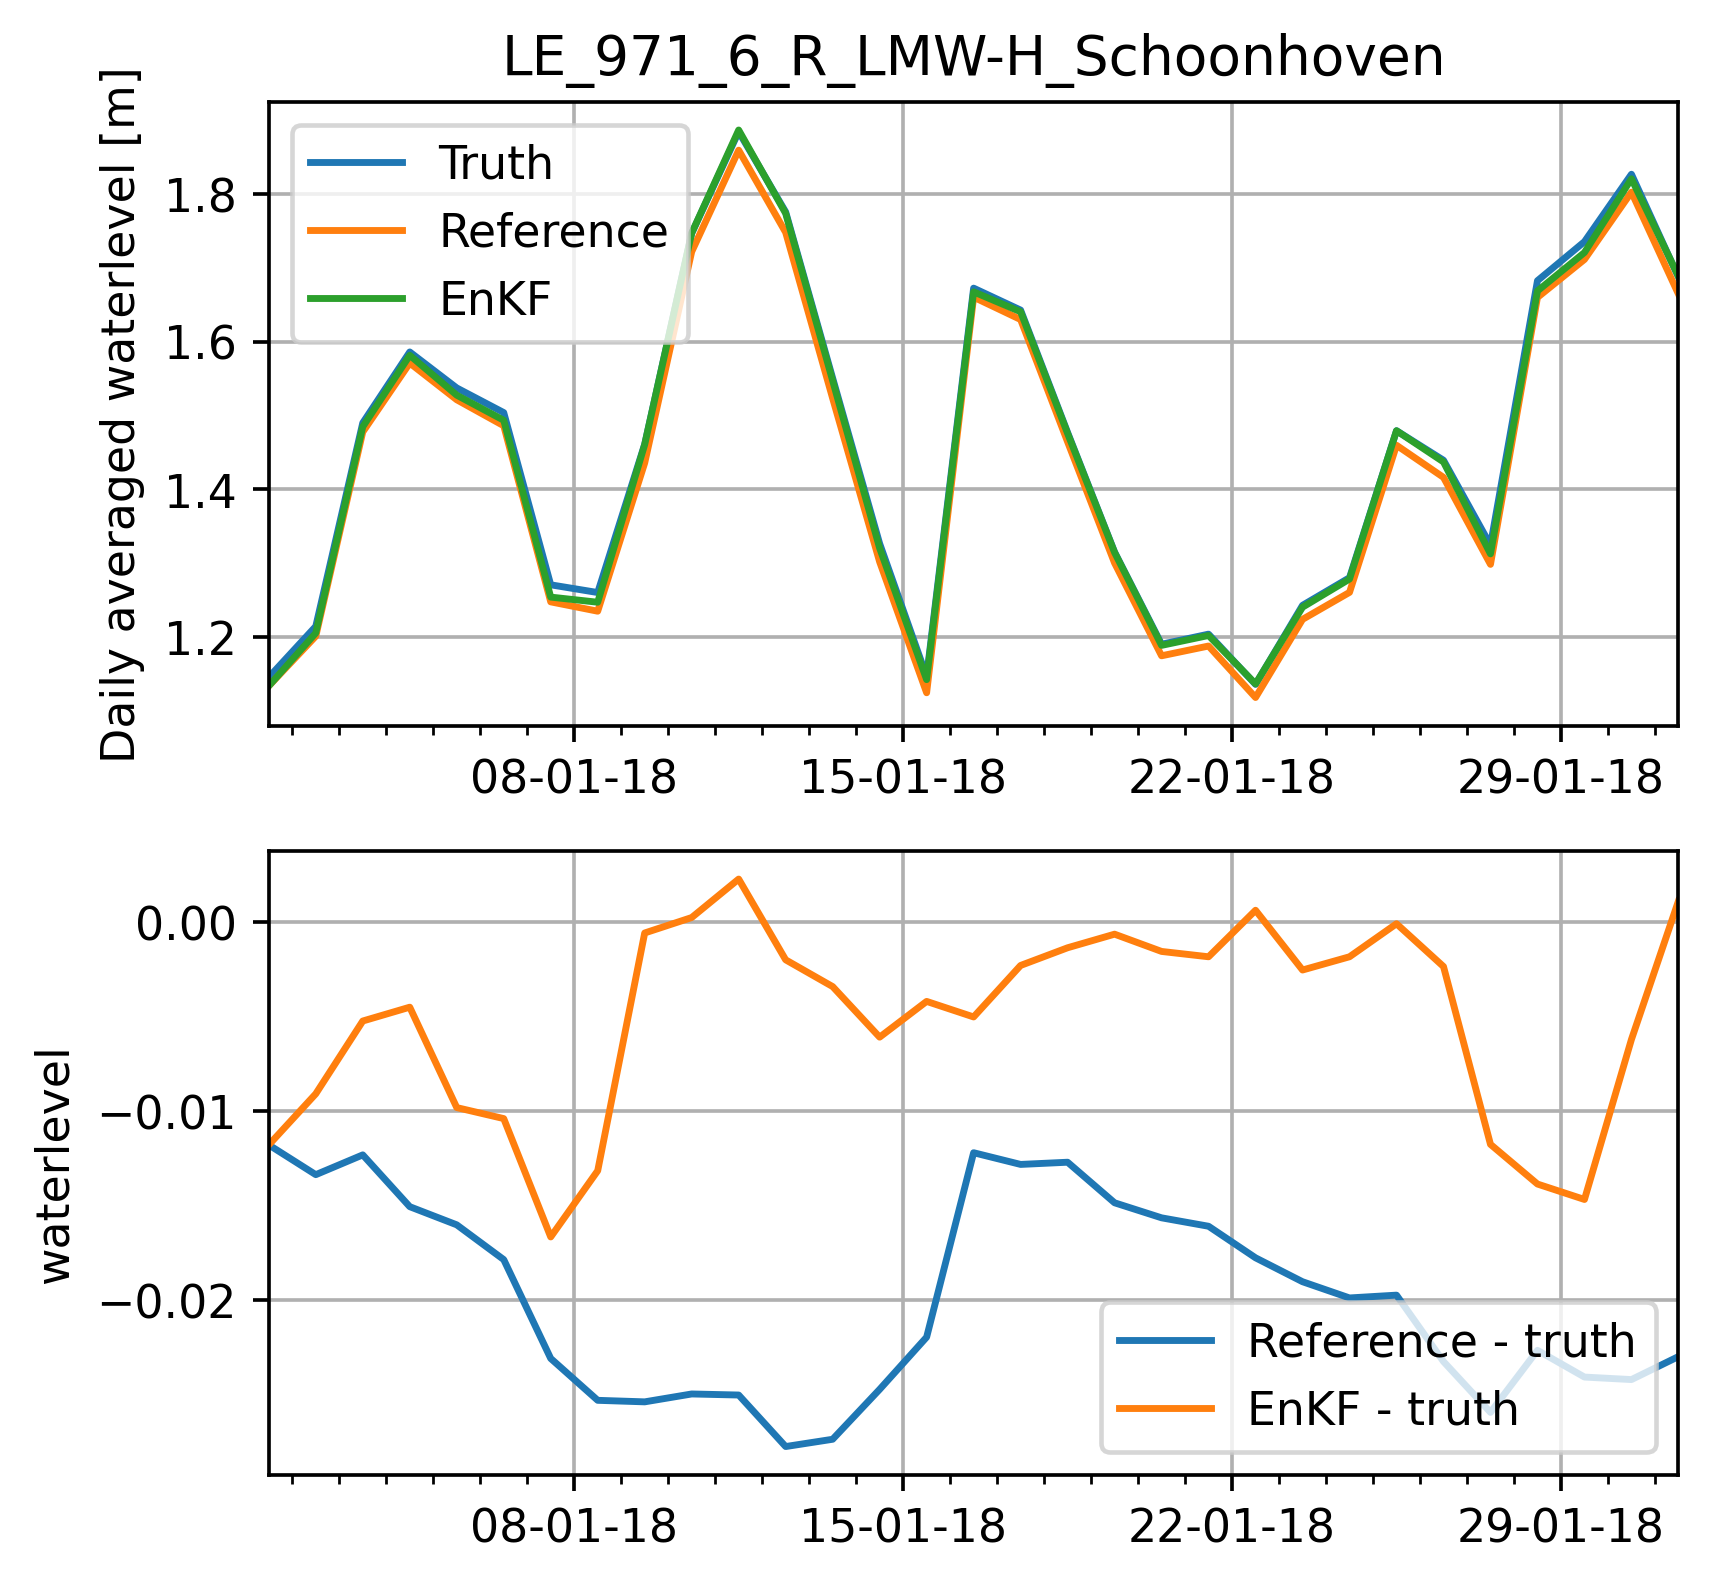

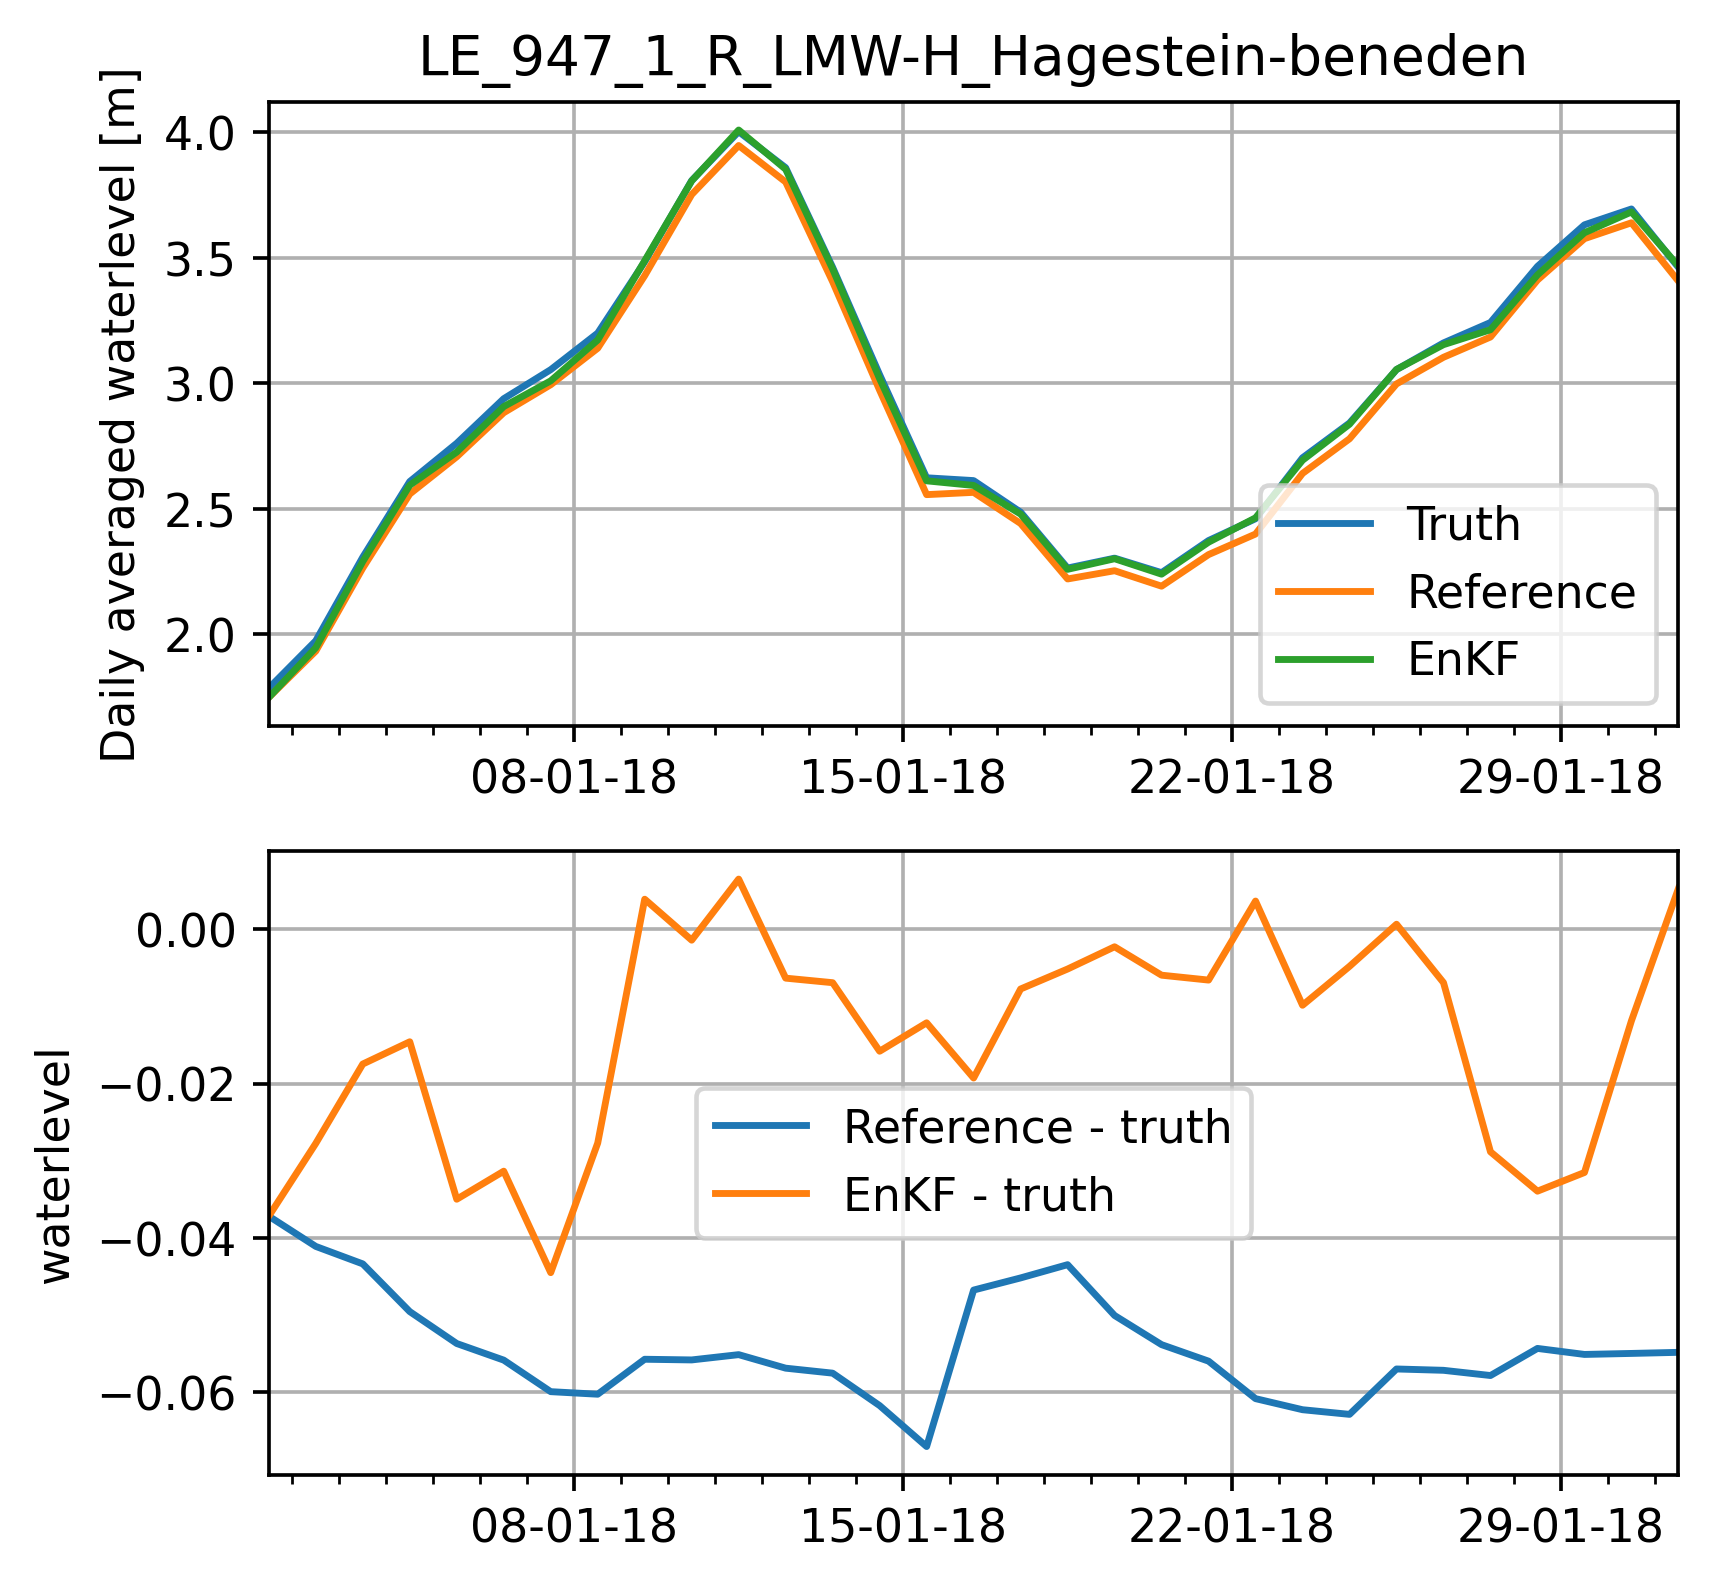

In [52]:
Truth_Results = xr.open_mfdataset(r'p:\11208053-004-kpp2022-rmm1d2d\C_Work\09_Validatie2018_2020\dflowfm2d-rmm_vzm-j19_6-v2d\computations\validation\KalmanFilterDischarge\Experiment_Outputs\Simulation_Discharge_Noise_20\work0\results\full_RMM_VZM_averaged_his.nc', 
                                    preprocess=dfmt.preprocess_hisnc)
Reference_Results = xr.open_mfdataset(r'p:\11208053-004-kpp2022-rmm1d2d\C_Work\09_Validatie2018_2020\dflowfm2d-rmm_vzm-j19_6-v2d\computations\validation\KalmanFilterDischarge\Experiment_Outputs\Simulation_Discharge_Noise_0\work0\results\full_RMM_VZM_averaged_his.nc', 
                                    preprocess=dfmt.preprocess_hisnc)
EnKF_Results = xr.open_mfdataset(r'p:\11208053-004-kpp2022-rmm1d2d\C_Work\09_Validatie2018_2020\dflowfm2d-rmm_vzm-j19_6-v2d\computations\validation\KalmanFilterDischarge\Experiment_Outputs\EnKF_Twin_Experiment_Noise_20\output\work0\results\full_RMM_VZM_averaged_his.nc', 
                                    preprocess=dfmt.preprocess_hisnc)

plot_stations =  ['LE_971_6_R_LMW-H_Schoonhoven', 
                 'LE_947_1_R_LMW-H_Hagestein-beneden']
#plot average timeseries
for station in plot_stations:
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(14*cm, 14*cm))
    Truth_Results['waterlevel'].sel(stations=station).plot(ax=ax1, label = 'Truth')
    Reference_Results['waterlevel'].sel(stations=station).plot(ax=ax1, label = 'Reference')
    EnKF_Results['waterlevel'].sel(stations=station).plot(ax=ax1, label = 'EnKF')
    ax1.grid('y')
    ax1.set_ylabel('Daily averaged waterlevel [m]')
    ax1.set_xlabel('')
    ax1.xaxis.set_major_locator(mdates.DayLocator(bymonthday=range(1,31, 7)))
    ax1.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))
    ax1.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    for label in ax1.get_xticklabels():
        label.set_horizontalalignment('center')
    ax1.set_xlim(left = Truth_Results['waterlevel'].time.data[0], 
                right = Truth_Results['waterlevel'].time.data[-1])
    ax1.tick_params(labelrotation=0)
    ax1.set_title(station)
    ax1.legend()

    #Plot difference compared to truth
    ref_diff = Reference_Results['waterlevel'].sel(stations=station) - Truth_Results['waterlevel'].sel(stations=station)
    enkf_diff = EnKF_Results['waterlevel'].sel(stations=station) - Truth_Results['waterlevel'].sel(stations=station)
    ax2.set_ylabel('Daily averaged waterlevel [m]')
    ref_diff.plot(ax=ax2, label = 'Reference - truth')
    enkf_diff.plot(ax=ax2, label = 'EnKF - truth')
    ax2.grid('y')
    ax2.set_xlabel('')
    ax2.xaxis.set_major_locator(mdates.DayLocator(bymonthday=range(1,31, 7)))
    ax2.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))
    ax2.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    for label in ax2.get_xticklabels():
        label.set_horizontalalignment('center')
    ax2.set_xlim(left = Truth_Results['waterlevel'].time.data[0], 
                right = Truth_Results['waterlevel'].time.data[-1])
    ax2.tick_params(labelrotation=0)
    ax2.set_title('')
    plt.legend()
